In [1]:

import json
import os
import csv
import re

import math
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf       # for ANOVA
import statsmodels.stats.multicomp as multi # for post hoc test 
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import preprocessing
import scipy.spatial.distance as distance
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.stats import skew
from pyquaternion import Quaternion
from matplotlib.backends.backend_pdf import PdfPages

from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
import math
import sys
import subprocess

# Import analysis Scripts
import nbimporter
import Analysis_Util as analysis_util

C:\Users\j3hartma\Anaconda3\envs\AEAnalysis\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Importing Jupyter notebook from Analysis_Util.ipynb


In [2]:
pd.set_option('display.max_columns', None)  
sns.set()
sns.set_style("whitegrid")


In [3]:
# Win 2
distalLocationAll = r'D:\GIT_DIR\CS846-Project\pullreqs\AllData_Distill.csv'

In [3]:

# OSX
distalLocationAll = r'/Volumes/Second_HD/GIT_DIR_2/cs846-Project/pullreqs/AllData_Distill.csv'

# Data Anlaysis

In [4]:
# Load data
alldata = pd.read_csv(distalLocationAll)

In [9]:
# Drop first column
alldata = alldata.drop(alldata.columns[0], axis=1)

In [ ]:
plt.figure(figsize=(16, 12))
sns.set(font_scale=5)
ax = sns.pointplot(x="lang", y="mergetime_minutes", hue="main_team_member",# col="TargetType", #col="isOccluded",
                   data=alldata, dodge=True, estimator=np.median, capsize=.1)

# RQ2 Lifecyle Characteristics

In [ ]:
alldata.

# Correlation Plot

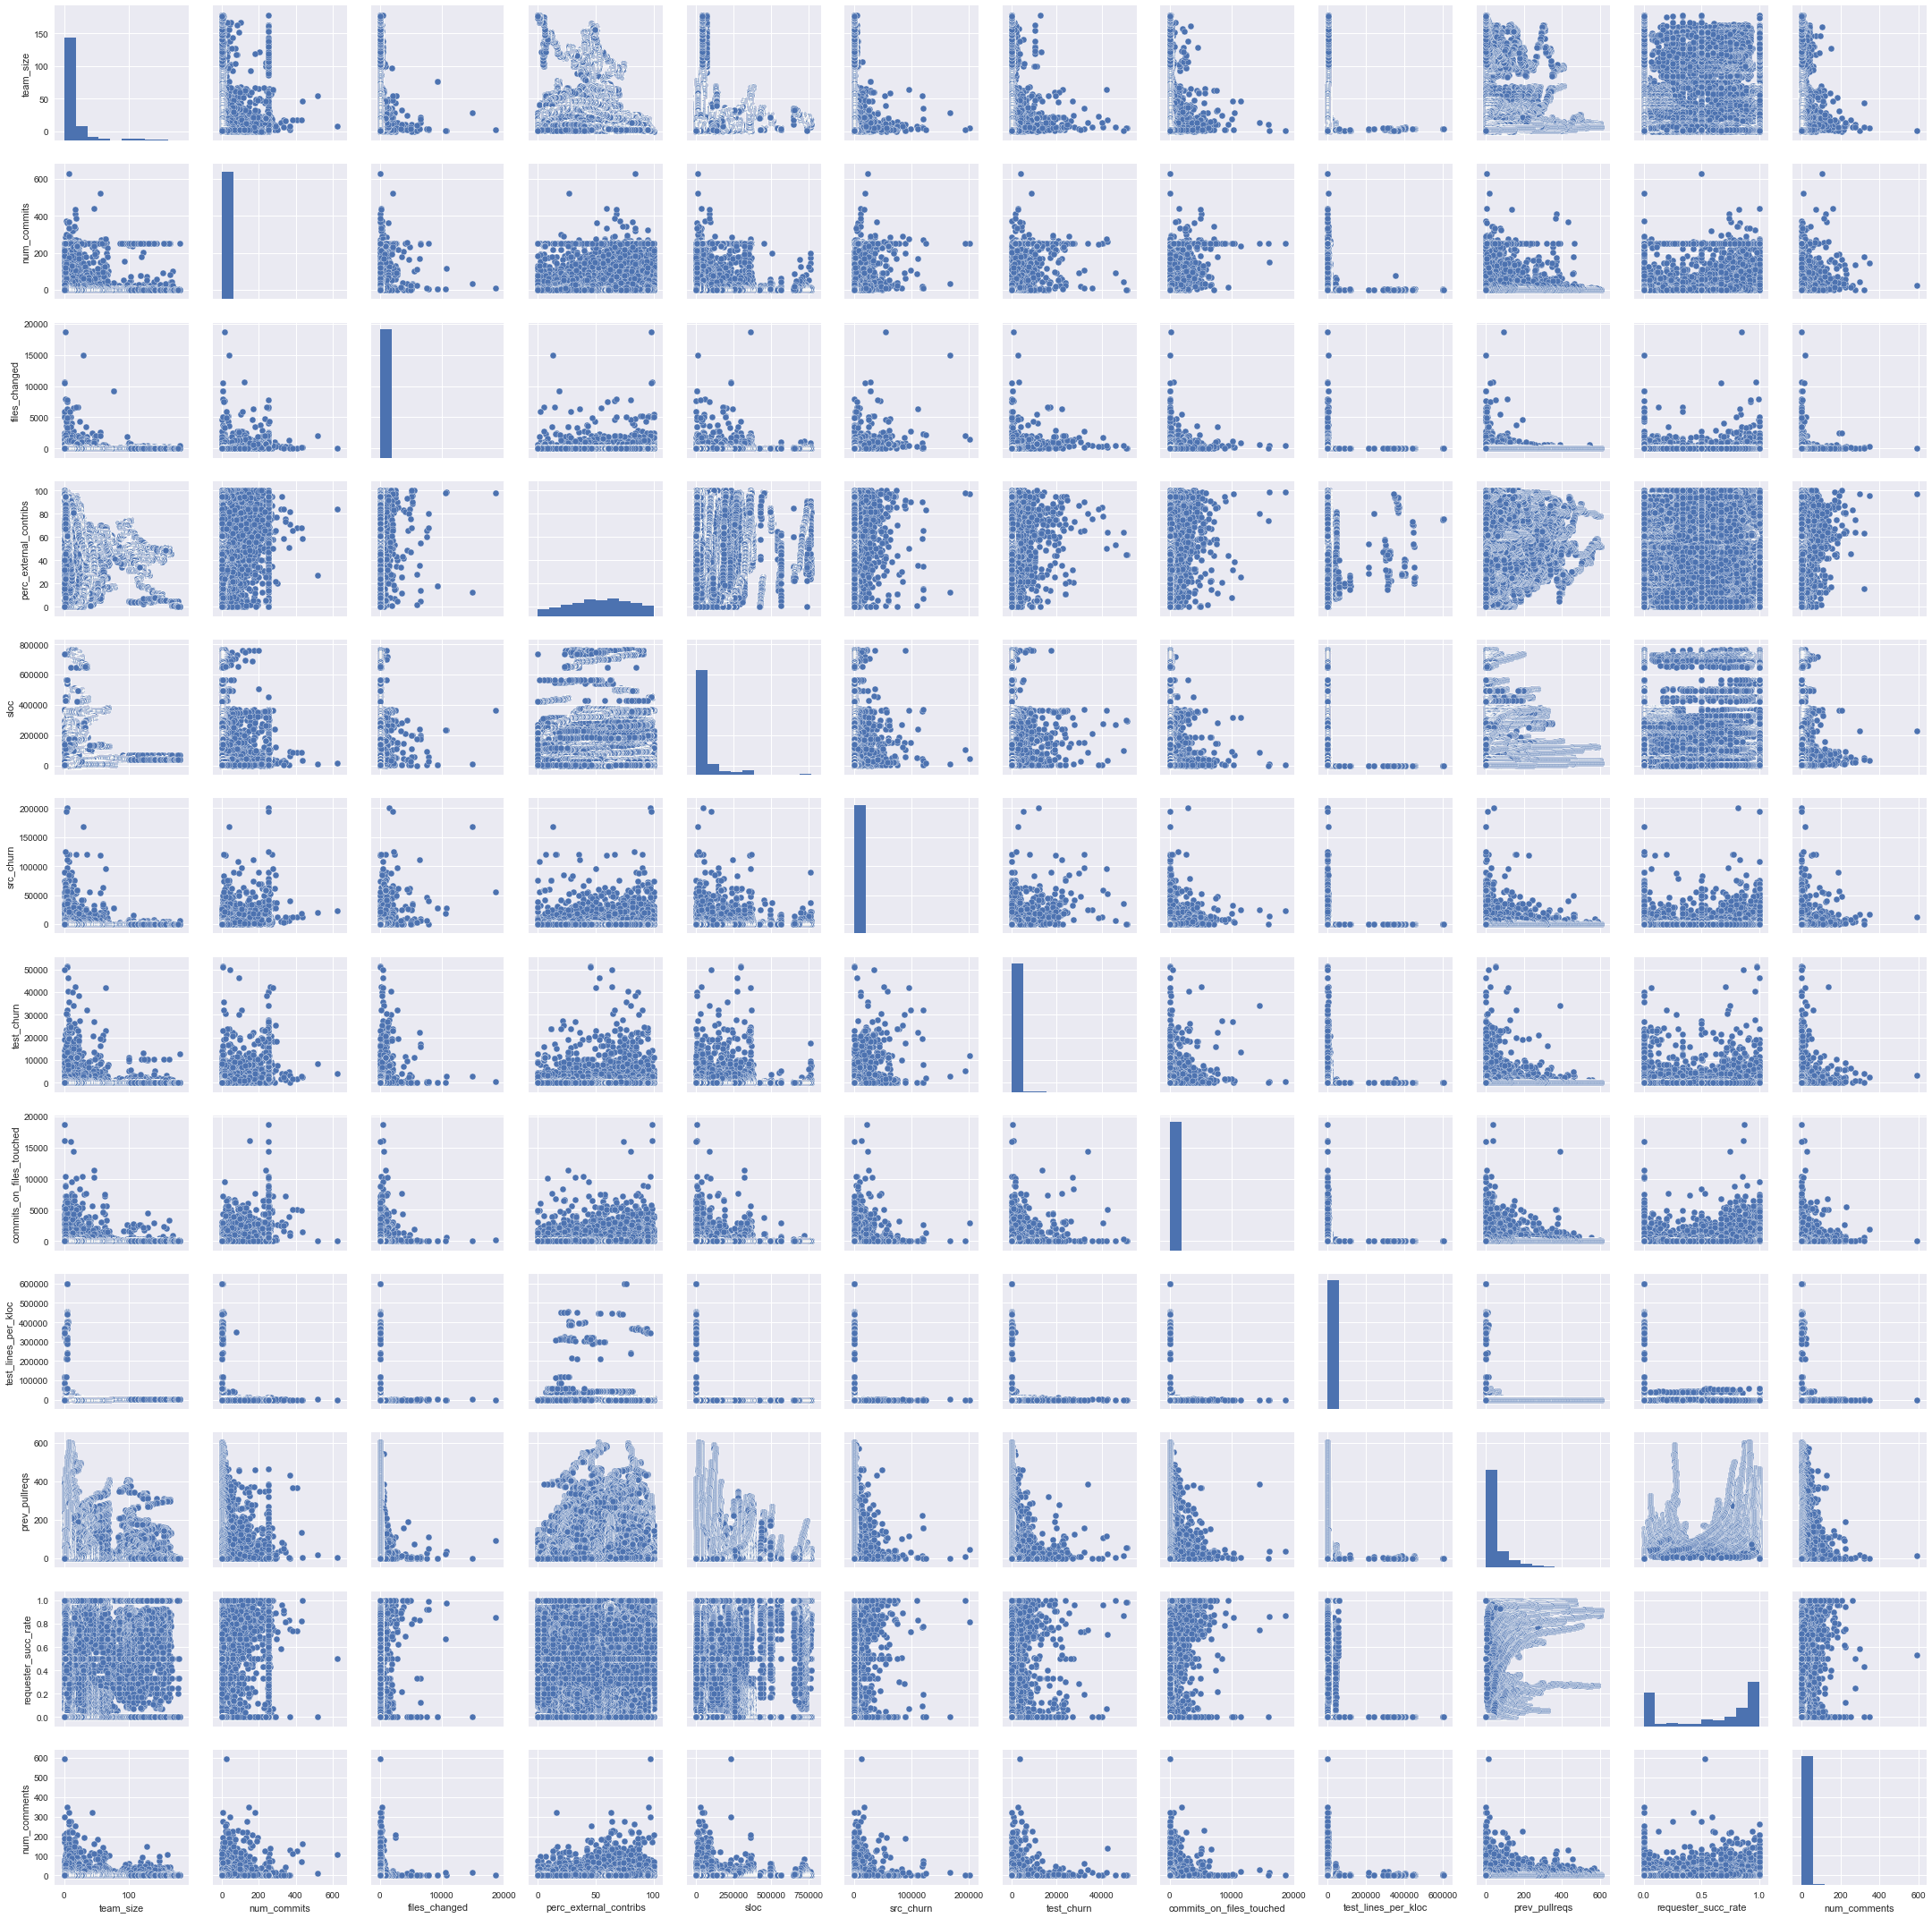

In [18]:
sns.pairplot(alldata[["team_size", "num_commits", "files_changed",
            "perc_external_contribs", "sloc", "src_churn", "test_churn",
            "commits_on_files_touched", "test_lines_per_kloc",
            "prev_pullreqs", "requester_succ_rate", "num_comments"]])


# Merge Stats

In [84]:
# Create merged ratio

mergeddata = (((alldata[['project_name', 'merged']][alldata.merged == True]).groupby(['project_name']).count()/
 alldata[['project_name', 'merged']].groupby(['project_name']).count()).sort_values('merged'))



In [87]:
mergeddata = mergeddata.reset_index()

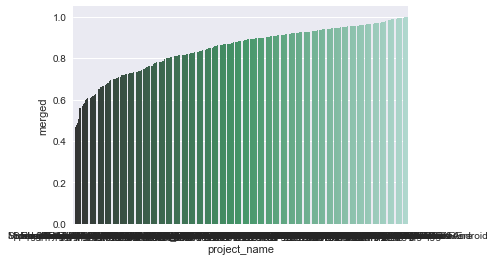

In [88]:
data = mergeddata
sns.barplot(x="project_name", y="merged", data=data, palette="BuGn_d")

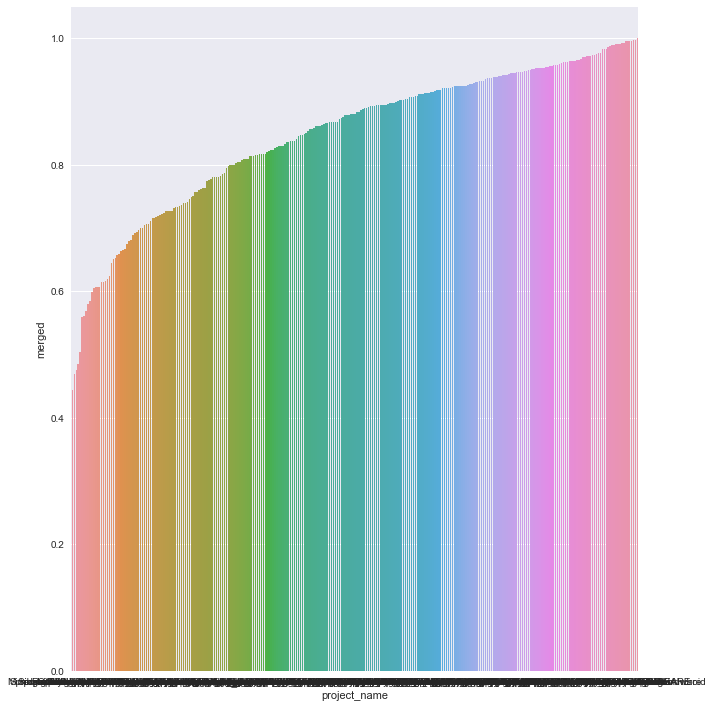

In [89]:
data = mergeddata#[alldata.isOccluded == True]
plt.figure(figsize=(16, 12))
ax = sns.factorplot(x="project_name", y="merged", 
                   kind="bar", data=data, dodge=True, capsize=.1, size=10)


# Pull Request

## Merge Time by Pull requests

In [124]:
math.log(, 10)

0.30102999566398114

In [12]:
## Group TargetTypes
alldata['mergetime_minutes_log'] = alldata['mergetime_minutes'].apply(
    lambda x: 
    math.log(float(x)) if x >= 1 else
    0
)
alldata['mergetime_minutes_log_bin'] = alldata['mergetime_minutes_log'].apply(
    lambda x: 
    0 if x != x else
    int(x) if x > 1 else
    int(x)
)

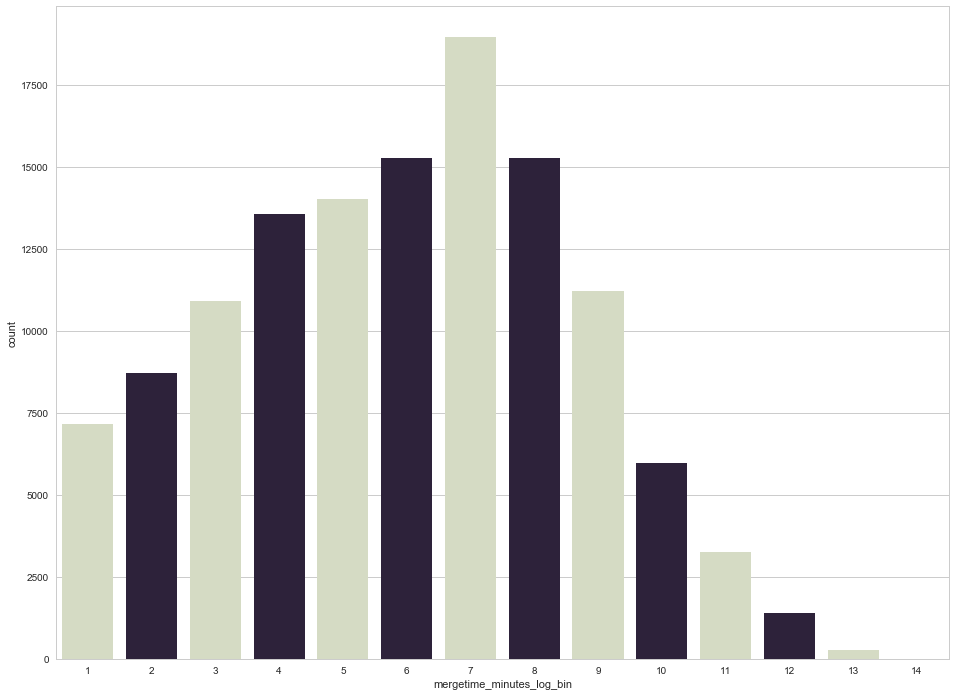

In [128]:
data = alldata[alldata.mergetime_minutes_log_bin >= 1]#[alldata.isOccluded == True]
plt.figure(figsize=(16, 12))
ax = sns.countplot(x="mergetime_minutes_log_bin", #hue="isOccluded", col="Condition",# col="TargetType",
                    palette=sns.cubehelix_palette(2, start=0.5, rot=-.75),
                   data=data)

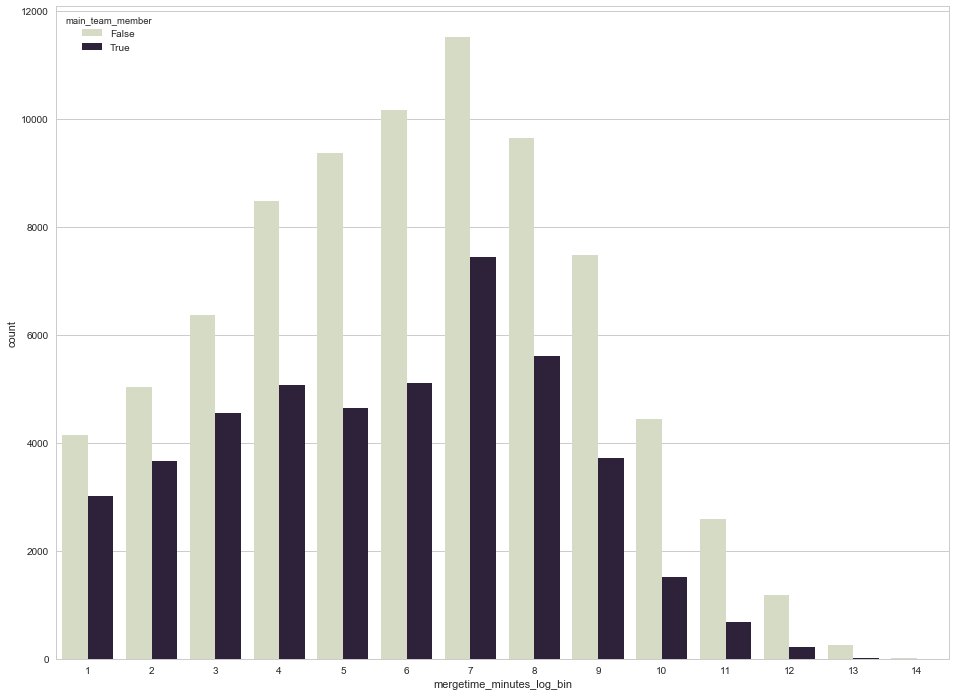

In [41]:
# With core team members
data = alldata[alldata.mergetime_minutes_log_bin >= 1]#[alldata.isOccluded == True]
plt.figure(figsize=(16, 12))
ax = sns.countplot(x="mergetime_minutes_log_bin", hue="main_team_member", #col="Condition",# col="TargetType",
                    palette=sns.cubehelix_palette(2, start=0.5, rot=-.75),
                   data=data)

## Lifetime of merged and unmerged pull requests

In [13]:
## Group TargetTypes
alldata['lifetime_minutes_log'] = alldata['lifetime_minutes'].apply(
    lambda x: 
    math.log(float(x)) if x >= 1 else
    0
)
alldata['lifetime_minutes_log_bin'] = alldata['lifetime_minutes_log'].apply(
    lambda x: 
    0 if x != x else
    int(x) if x > 1 else
    int(x)
)

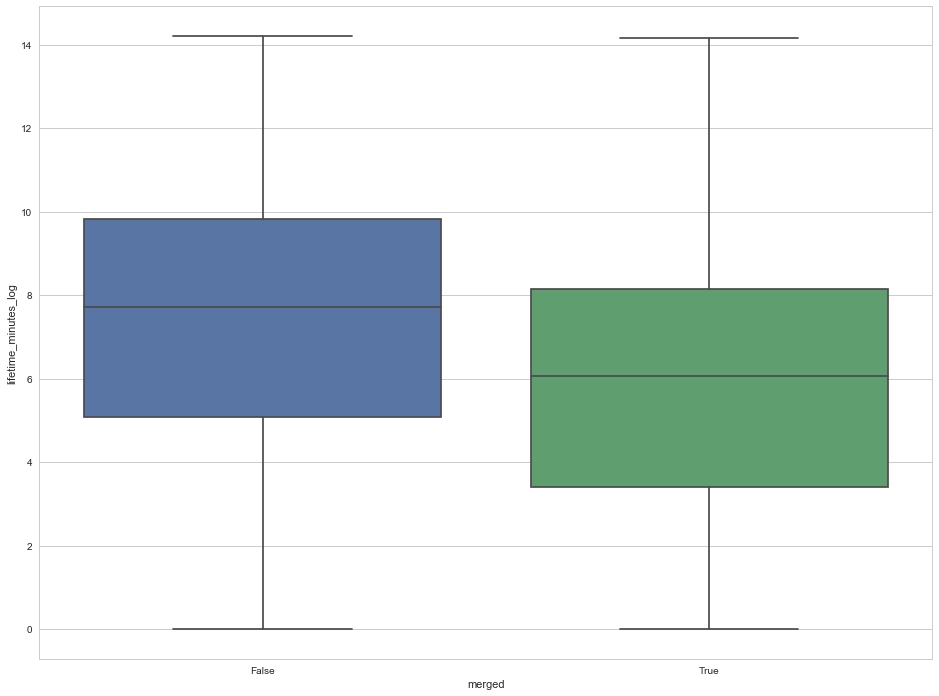

In [15]:
data=alldata
plt.figure(figsize=(16, 12))
sns.boxplot(x="merged", y="lifetime_minutes_log", data=data)

In [16]:
# Compute the correlation matrix
corr = alldata.corr()

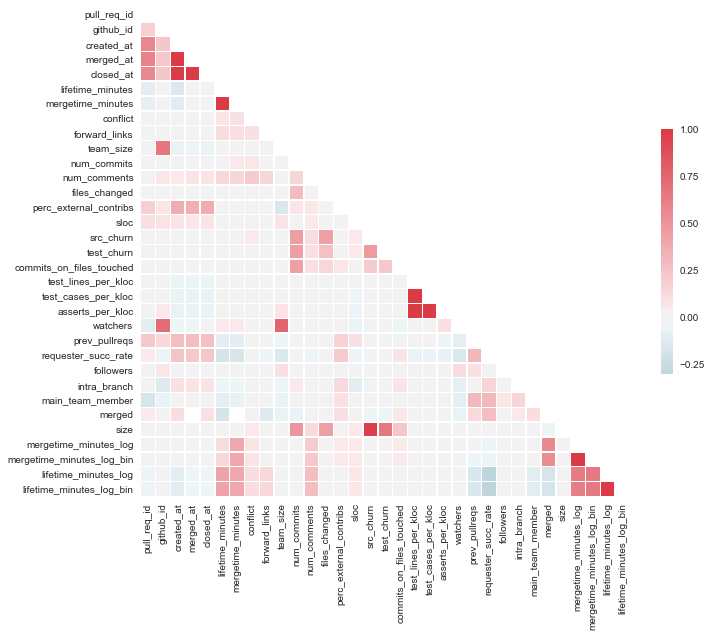

In [19]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Quantile ANalysis

In [10]:
alldata.describe()

,pull_req_id,github_id,created_at,merged_at,closed_at,lifetime_minutes,mergetime_minutes,team_size,num_commits,num_comments,files_changed,perc_external_contribs,sloc,src_churn,test_churn,commits_on_files_touched,test_lines_per_kloc,test_cases_per_kloc,asserts_per_kloc,watchers,prev_pullreqs,requester_succ_rate,followers,size
count,1.668840e+05,166884.000000,1.668840e+05,1.414680e+05,1.668840e+05,1.668840e+05,1.414680e+05,166884.000000,166884.00000,166884.000000,166884.00000,166884.000000,166884.000000,166884.000000,166884.000000,166884.000000,166884.000000,166884.000000,166884.000000,166884.000000,166884.000000,166884.000000,166884.000000,166884.000000
mean,9.647265e+05,1057.105660,1.347475e+09,1.349107e+09,1.348300e+09,1.373898e+04,9.503363e+03,15.370779,4.46609,2.765292,12.11943,52.812229,60897.874002,300.718877,88.876369,52.387053,1002.613432,67.292626,145.663394,1505.435123,45.106349,0.591453,19.623068,389.595246
std,5.737968e+05,1617.268856,2.189163e+07,2.111008e+07,2.167864e+07,5.623668e+04,4.184100e+04,25.026560,18.09755,7.479556,124.54330,25.957289,105534.934570,2393.530968,742.491165,242.505196,9924.189401,643.888181,885.378916,4068.040338,72.768499,0.401489,94.633786,2820.774609
min,6.354000e+03,1.000000,1.283272e+09,1.283274e+09,1.283274e+09,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000,0.00000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.838735e+05,230.000000,1.332879e+09,1.335177e+09,1.333996e+09,3.700000e+01,3.000000e+01,4.000000,1.00000,0.000000,1.00000,33.000000,8048.000000,0.000000,0.000000,0.000000,160.599572,6.496348,18.787670,18.000000,2.000000,0.037037,1.000000,2.000000
50%,8.766800e+05,512.000000,1.351719e+09,1.353345e+09,1.352728e+09,5.790000e+02,4.280000e+02,7.000000,1.00000,1.000000,2.00000,54.000000,26036.000000,10.000000,0.000000,5.000000,440.800153,18.506484,53.631361,100.000000,14.000000,0.780822,4.000000,17.000000
75%,1.477042e+06,1112.000000,1.365467e+09,1.366421e+09,1.366088e+09,4.437000e+03,3.495000e+03,15.000000,3.00000,3.000000,5.00000,73.000000,53347.000000,68.000000,11.000000,29.000000,910.879068,55.620316,138.552379,991.000000,57.000000,0.946809,14.000000,106.000000
max,2.038464e+06,12126.000000,1.378272e+09,1.378273e+09,1.378273e+09,1.472118e+06,1.419863e+06,178.000000,628.00000,594.000000,18680.00000,100.000000,767658.000000,200615.000000,51404.000000,18619.000000,601090.909091,38818.181818,52090.909091,59298.000000,604.000000,1.000000,13438.000000,212444.000000


In [7]:
alldata["main_team_member"][alldata.main_team_member == True].count()

57323

In [8]:
alldata["main_team_member"][alldata.main_team_member == True].count()

109561

In [11]:
alldata["main_team_member"].count()

166884

## Number of Commits

In [22]:
alldata.num_commits.quantile(q=[0.80, 0.90, 0.95])

0.80     3.0
0.90     6.0
0.95    12.0
Name: num_commits, dtype: float64

In [31]:
alldata[alldata.main_team_member == True].num_commits.quantile(q=[0.80, 0.90, 0.95])

0.80     4.0
0.90     7.0
0.95    14.0
Name: num_commits, dtype: float64

In [32]:
alldata[alldata.main_team_member == False].num_commits.quantile(q=[0.80, 0.90, 0.95])

0.80     3.0
0.90     6.0
0.95    11.0
Name: num_commits, dtype: float64

## Files Changed

In [24]:
alldata.files_changed.quantile(q=[0.80, 0.90, 0.95])

0.80     7.0
0.90    15.0
0.95    31.0
Name: files_changed, dtype: float64

In [34]:
alldata[alldata.main_team_member == True].files_changed.quantile(q=[0.80, 0.90, 0.95])

0.80     9.0
0.90    19.0
0.95    38.0
Name: files_changed, dtype: float64

In [33]:
alldata[alldata.main_team_member == False].files_changed.quantile(q=[0.80, 0.90, 0.95])

0.80     6.0
0.90    12.0
0.95    26.0
Name: files_changed, dtype: float64

## Test churn

In [27]:
alldata['churn_all'] = alldata.test_churn + alldata.src_churn
alldata.churn_all.quantile(q=[0.80, 0.90, 0.95])

0.80     162.0
0.90     489.0
0.95    1213.0
Name: churn_all, dtype: float64

In [35]:
alldata[alldata.main_team_member == True].churn_all.quantile(q=[0.80, 0.90, 0.95])

0.80     232.0
0.90     661.0
0.95    1573.9
Name: churn_all, dtype: float64

In [36]:
alldata[alldata.main_team_member == False].churn_all.quantile(q=[0.80, 0.90, 0.95])

0.80     130.0
0.90     402.0
0.95    1029.0
Name: churn_all, dtype: float64

In [50]:
alldata.churn_all.mean()

389.5952457994775

In [45]:
alldata[alldata.main_team_member == True].churn_all.median()

28.0

In [44]:
alldata[alldata.main_team_member == False].churn_all.median()

13.0

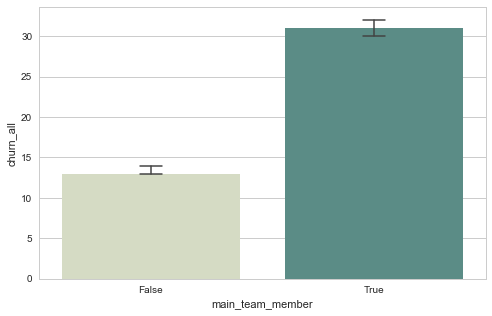

In [46]:
# Alldata excuding table
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="main_team_member", y="churn_all",# col="TargetType", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))

# # Axis
# ax.set(xlabel='Technique', ylabel='MT')

# groupedCondtion = alldata[["Condition", "TotalTime"]].groupby("Condition").median()
# print(groupedCondtion)

## Merge Time

In [59]:
alldata.mergetime_minutes.quantile(q=[0.05, 0.25, 0.50, 0.65 ,0.80, 0.90, 0.95])

0.05        0.0
0.25       30.0
0.50      428.0
0.65     1395.0
0.80     5478.0
0.90    15827.3
0.95    38985.3
Name: mergetime_minutes, dtype: float64

In [62]:
alldata[alldata.main_team_member == True].mergetime_minutes.quantile(q=[0.05, 0.25, 0.50, 0.69 ,0.80, 0.90, 0.95])

0.05        0.0
0.25       19.0
0.50      278.0
0.69     1428.0
0.80     4026.0
0.90     9668.8
0.95    20939.4
Name: mergetime_minutes, dtype: float64

In [66]:
alldata[alldata.main_team_member == False].mergetime_minutes.quantile(q=[0.05, 0.25, 0.50, 0.63 ,0.80, 0.90, 0.95])

0.05        0.0
0.25       41.0
0.50      518.0
0.63     1394.0
0.80     6622.6
0.90    20371.8
0.95    52990.8
Name: mergetime_minutes, dtype: float64

## Number of Comments

In [81]:
alldata.num_comments.mean()

2.765292059154862

In [71]:
alldata[alldata.main_team_member == True].num_comments.median()

0.0

In [72]:
alldata[alldata.main_team_member == False].num_comments.median()

1.0

In [79]:
alldata[alldata.main_team_member == False].num_comments.quantile(q=[0.05, 0.25, 0.50, 0.60 ,0.80, 0.90, 0.95])

0.05     0.0
0.25     0.0
0.50     1.0
0.60     1.0
0.80     4.0
0.90     7.0
0.95    12.0
Name: num_comments, dtype: float64

In [78]:
alldata[alldata.main_team_member == True].num_comments.quantile(q=[0.05, 0.25, 0.50, 0.60 ,0.80, 0.90, 0.95])

0.05     0.0
0.25     0.0
0.50     0.0
0.60     1.0
0.80     3.0
0.90     7.0
0.95    11.0
Name: num_comments, dtype: float64

## Test Code analysis

In [13]:
## Group TargetTypes
alldata['test_cases_presented'] = alldata['test_churn'].apply(
    lambda x: 
    True if x > 0 else
    False
)

In [14]:
print(alldata[alldata.test_churn == 0]['pull_req_id'].count())
print(alldata[alldata.test_churn > 0]['pull_req_id'].count())

112517
54367


In [82]:
alldata[alldata.test_churn > 0].mergetime_minutes.mean()

13170.691105346465

In [83]:
alldata[alldata.test_churn == 0].mergetime_minutes.mean()

7765.2992602625545

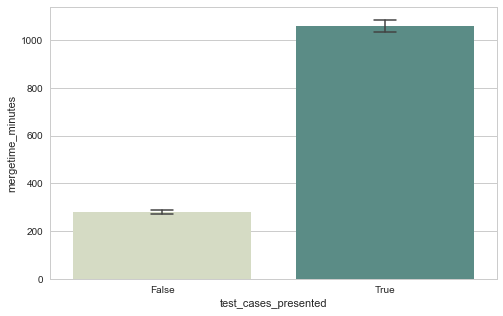

In [15]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="test_cases_presented", y="mergetime_minutes", #hue="main_team_member", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))


In [17]:
print(alldata[alldata.test_cases_presented == True].mergetime_minutes.median())
print(alldata[alldata.test_cases_presented == False].mergetime_minutes.median())

1060.0
280.0


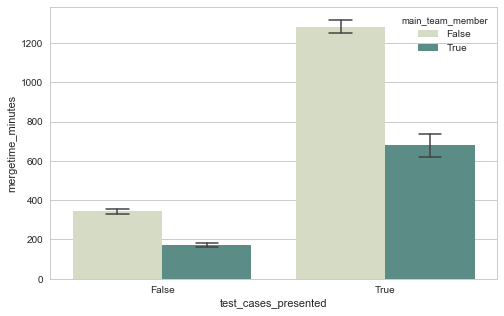

In [97]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="test_cases_presented", y="mergetime_minutes", hue="main_team_member", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))



In [98]:
data=alldata[alldata.merged == True]
stats.mannwhitneyu(data.test_cases_presented, data.mergetime_minutes)

MannwhitneyuResult(statistic=968018912.0, pvalue=0.0)

In [102]:
data = alldata[alldata.merged == True]
analysis_util.ezanova(data, "mergetime_minutes", "test_cases_presented", ['test_churn'])

FAIL __temp__.R 1
Error in ezANOVA_main(data = data, dv = dv, wid = wid, within = within,  : 
  One or more cells is missing data. Try using ezDesign() to check your data.
Calls: ezANOVA -> ezANOVA_main
Execution halted

False


# Core-Team Membership Analysis

In [6]:
alldata[alldata.merged == True].mergetime_minutes.count()

141468

In [5]:
data=alldata[alldata.merged == True]
core = data[data.main_team_member == True].mergetime_minutes.count()
noncore = data[data.main_team_member == False].mergetime_minutes.count()
print("NonCore: {}".format(noncore))
print("Core   : {}".format(core))
print("Ratio  : {}".format(core/noncore))

NonCore: 89603
Core   : 51865
Ratio  : 0.578831065924132


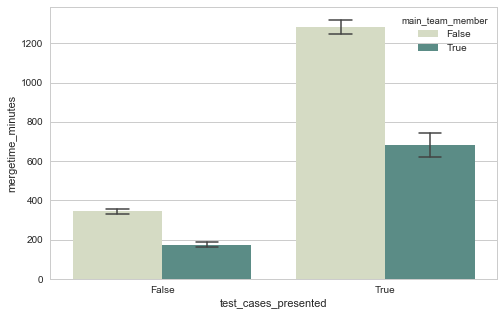

In [104]:
# Alldata excuding table
data=alldata#[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="test_cases_presented", y="mergetime_minutes", hue="main_team_member", #col="merged",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))


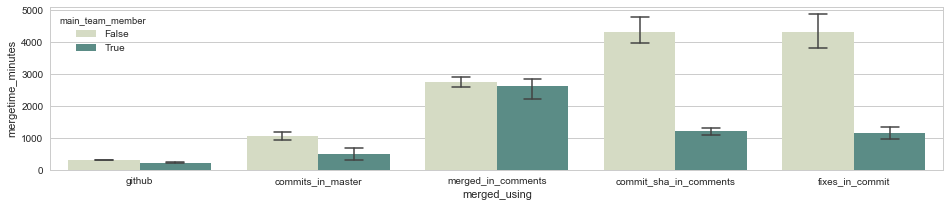

In [107]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(16, 3))
ax = sns.barplot(x="merged_using", y="mergetime_minutes", hue="main_team_member", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))


In [133]:
data=alldata[alldata.merged == True]
data=data[data.main_team_member == False]
# stats.mannwhitneyu(data.mergetime_minutes, data.lang)

analysis_util.car_anova(data, "mergetime_minutes", "project_name", ['merged_using'], ez_type=2)

Anova Table (Type II tests)

Response: mergetime_minutes
                 Sum Sq    Df F value    Pr(>F)    
merged_using 9.3328e+12     4  1005.8 < 2.2e-16 ***
Residuals    2.0784e+14 89598                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

	Pairwise comparisons using t tests with pooled SD 

data:  df$mergetime_minutes and df$merged_using 

                   commit_sha_in_comments commits_in_master fixes_in_commit
commits_in_master  < 2e-16                -                 -              
fixes_in_commit    0.084                  < 2e-16           -              
github             < 2e-16                < 2e-16           < 2e-16        
merged_in_comments < 2e-16                5.8e-15           2.2e-15        
                   github 
commits_in_master  -      
fixes_in_commit    -      
github             -      
merged_in_comments < 2e-16

P value adjustment method: holm 



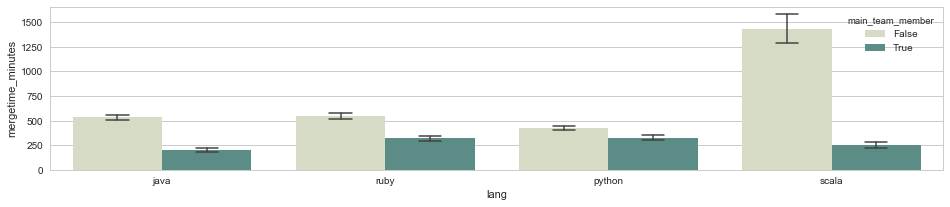

In [117]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(16, 3))
ax = sns.barplot(x="lang", y="mergetime_minutes", hue="main_team_member", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))


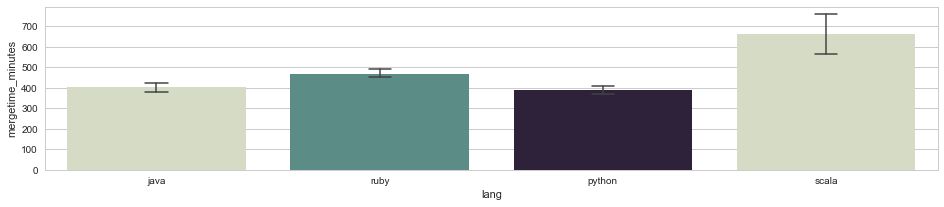

In [9]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(16, 3))
ax = sns.barplot(x="lang", y="mergetime_minutes",# hue="main_team_member", #col="isOccluded",
                   data=data, dodge=True, estimator=np.median, 
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))

In [132]:
data=alldata[alldata.merged == True]
data=data[data.main_team_member == False]
# stats.mannwhitneyu(data.mergetime_minutes, data.lang)

analysis_util.car_anova(data, "mergetime_minutes", "project_name", ['lang'], ez_type=2)

Anova Table (Type II tests)

Response: mergetime_minutes
              Sum Sq    Df F value    Pr(>F)    
lang      1.2557e+12     3  173.69 < 2.2e-16 ***
Residuals 2.1591e+14 89599                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

	Pairwise comparisons using t tests with pooled SD 

data:  df$mergetime_minutes and df$lang 

       java    python  ruby   
python 7.5e-08 -       -      
ruby   < 2e-16 < 2e-16 -      
scala  0.37    0.37    6.6e-15

P value adjustment method: holm 



In [134]:
data=alldata[alldata.merged == True]
data=data[data.main_team_member == False]
print(data[data.lang == "scala"].mergetime_minutes.median())
print(data[data.lang == "python"].mergetime_minutes.median())
print(data[data.lang == "ruby"].mergetime_minutes.median())
print(data[data.lang == "java"].mergetime_minutes.median())

1430.0
421.0
545.0
533.0


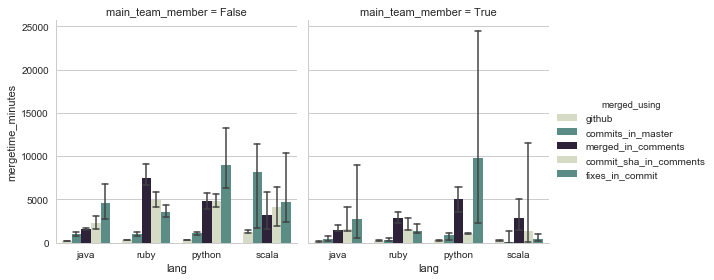

In [115]:
# Alldata excuding table
data=alldata[alldata.merged == True]
sns.set_style("whitegrid")
plt.figure(figsize=(20, 3))
sns.factorplot(x="lang", y="mergetime_minutes", hue="merged_using", col="main_team_member",
                   data=data, dodge=True, estimator=np.median, kind="bar",
                   capsize=.1, errwidth=1.5, palette=sns.cubehelix_palette(3, start=0.5, rot=-.75))


# Scrap

In [85]:
alldata

,pull_req_id,project_name,lang,github_id,created_at,merged_at,closed_at,lifetime_minutes,mergetime_minutes,merged_using,conflict,forward_links,team_size,num_commits,num_comments,files_changed,perc_external_contribs,sloc,src_churn,test_churn,commits_on_files_touched,test_lines_per_kloc,test_cases_per_kloc,asserts_per_kloc,watchers,requester,prev_pullreqs,requester_succ_rate,followers,intra_branch,main_team_member,merged,size,mergetime_minutes_log,mergetime_minutes_log_bin,lifetime_minutes_log,lifetime_minutes_log_bin,churn_all,test_cases_presented
0,1998470,A24Group/ssGWT-lib,java,220,1377693657,1.377748e+09,1377748331,911,911.0,github,False,False,6,1,2,1,72,14939,0,0,2,43.376397,2.208983,4.953477,5,nauderuan,25,0.960000,5,True,False,True,0,6.814543,6,6.814543,6,0,False
1,1904236,A24Group/ssGWT-lib,java,219,1375887412,1.375937e+09,1375937076,827,827.0,github,False,False,7,1,1,1,74,14935,22,0,2,43.388015,2.209575,4.954804,4,Rynoh,11,1.000000,6,True,False,True,22,6.717805,6,6.717805,6,22,False
2,1857406,A24Group/ssGWT-lib,java,218,1375078176,1.375106e+09,1375106235,467,467.0,github,False,False,7,2,4,1,74,14656,15,0,8,44.213974,2.251638,5.049127,4,michaelbarnard,42,0.928571,10,False,False,True,15,6.146329,6,6.146329,6,15,False
3,1807435,A24Group/ssGWT-lib,java,217,1374499015,1.374499e+09,1374499279,4,4.0,github,False,False,7,1,1,1,74,14656,0,0,0,44.213974,2.251638,5.049127,4,Sh33pman,35,1.000000,8,True,False,True,0,1.386294,1,1.386294,1,0,False
4,1805341,A24Group/ssGWT-lib,java,216,1374475132,1.375344e+09,1375344074,14482,14482.0,github,False,False,7,3,6,8,74,14656,831,0,0,44.213974,2.251638,5.049127,4,nauderuan,24,0.958333,5,True,False,True,831,9.580662,9,9.580662,9,831,False
5,2006608,A24Group/ssGWT-lib,java,215,1374239632,1.374240e+09,1374240401,12,12.0,github,False,False,7,0,1,0,75,14655,0,0,0,44.216991,2.251791,5.049471,4,Sh33pman,34,1.000000,8,True,False,True,0,2.484907,2,2.484907,2,0,False
6,1790115,A24Group/ssGWT-lib,java,214,1374143769,1.374145e+09,1374144839,17,17.0,github,False,False,6,1,4,2,76,11969,54,0,2,54.390509,2.757123,6.182638,4,michaelbarnard,41,0.926829,10,False,False,True,54,2.833213,2,2.833213,2,54,False
7,1784253,A24Group/ssGWT-lib,java,213,1374052641,1.374053e+09,1374052692,0,0.0,github,False,False,6,1,1,1,76,11969,2,0,1,54.390509,2.757123,6.182638,4,NeilNienaber,3,1.000000,0,True,False,True,2,0.000000,0,0.000000,0,2,False
8,1784226,A24Group/ssGWT-lib,java,212,1374052182,1.374053e+09,1374052517,5,5.0,github,False,False,6,1,1,1,76,11966,12,0,0,54.404145,2.757814,6.184189,4,NeilNienaber,2,1.000000,0,True,False,True,12,1.609438,1,1.609438,1,12,False
9,1773012,A24Group/ssGWT-lib,java,210,1373886855,1.373900e+09,1373899963,218,218.0,github,False,False,6,1,2,1,76,11966,0,0,4,54.404145,2.757814,6.184189,4,AlecErasmus,56,0.964286,3,True,False,True,0,5.384495,5,5.384495,5,0,False


In [18]:
alldata.iloc[:,7:32].columns

Index(['lifetime_minutes', 'mergetime_minutes', 'merged_using', 'conflict',
       'forward_links', 'team_size', 'num_commits', 'num_comments',
       'files_changed', 'perc_external_contribs', 'sloc', 'src_churn',
       'test_churn', 'commits_on_files_touched', 'test_lines_per_kloc',
       'test_cases_per_kloc', 'asserts_per_kloc', 'watchers', 'requester',
       'prev_pullreqs', 'requester_succ_rate', 'followers', 'intra_branch',
       'main_team_member', 'merged'],
      dtype='object')